In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
hist_size = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
#Better average, 1 training epoch, less noise, tweak on range

cuda


In [2]:
class my_roll():
    def __init__(self, array, max_len):
        self.array = array
        self.max_len = int(max_len)
        
    def append(self, element): #Newest on top
        if self.array.shape[0] >= self.max_len:
            self.array = torch.roll(self.array, 1, 0)
            try:
                self.array[0] = element
            except:
                self.array[0, :] = element
        else:
            shp = (-1,) + self.array.size()[1:]
            self.array = torch.cat((torch.reshape(element, shp), self.array))

In [3]:
class WPTsystem():
    def __init__(self, hist_size):
        self.hist_size = hist_size
        Ls = 9.998011536905373e-06
        Cp = 3.506620587986060e-07
        Cs = 9.416255285594627e-07
        LcP= 1.372127859274546e-05
        LcS= 2.600000000000000e-05
        Csec=1.500000000000000e-07
        R = 1.25
        k = 0.3
        M = k * np.sqrt(LcS * LcP)
        Z = M**2 - LcP * LcS
        R_par = 15e-3
        self.Vpri = 40
        self.B = torch.zeros((6, 1))
        self.B[0, 0] = self.Vpri/Ls
        self.A = torch.zeros((6, 6))
        self.A[0, 0] = -R_par / Ls
        self.A[0, 1] = -1/Ls
        self.A[1, 0] = 1/Cp
        self.A[1, 3] = -1/Cp
        self.A[2, 3] = 1/Cs
        self.A[3, 1] = -LcS/Z
        self.A[3, 2] = LcS/Z
        self.A[3, 3] = LcS * R_par/Z
        self.A[3, 4] = -M*(R+R_par)/Z
        self.A[3, 5] = M/Z
        self.A[4, 1] = M/Z
        self.A[4, 2] = -M/Z
        self.A[4, 3] = -M*R_par/Z
        self.A[4, 4] = LcP * (R+R_par)/Z
        self.A[4, 5] = -LcP/Z
        self.A[5, 4] = -1/Csec
    
        self.Ainv = torch.linalg.inv(self.A)
        self.Ainv2= self.Ainv @ self.Ainv
        self.AinvB = self.Ainv @ self.B
        
        M1 = torch.matrix_exp(0.5/85000*self.A)
        self.hidden_state = torch.linalg.inv(M1 + torch.eye(6)) @ (M1 - torch.eye(6)) @ self.Ainv @ self.B
        
        self.timeT = 0
        self.timeL = 500/45000
        
        self.aug_state = my_roll(torch.zeros((0, 1)), hist_size) #Shows past actions and measured outputs
        
        self.pow_hist = my_roll(torch.zeros((0, 2)), 2) #Get average power of last 4 outputs
    
    def reset(self):
        M1 = torch.matrix_exp(0.5/85000*self.A)
        self.hidden_state = torch.linalg.inv(M1 + torch.eye(6)) @ (M1 - torch.eye(6)) @ self.Ainv @ self.B
        self.aug_state = my_roll(torch.zeros((0, 1)), self.hist_size) #Shows past actions and measured outputs
        self.timeT = 0
        self.pow_hist = my_roll(torch.zeros((0, 2)), 4) #Get average power of last 4 outputs           
        #Observation of current during last step - nothing since we haven't begun switching
        return self.aug_state.array.clone(), 0, False
        
    def step(self, act):
        on_time = act * 1e-6 
        phi = torch.matrix_exp(self.A * on_time)
        phi_half = torch.matrix_exp(self.A * on_time/2)
        
        #phi = (self.V @ torch.exp(self.D * on_time) @ self.Vinv).real
        
        
        x_half = phi @ self.hidden_state + (phi-torch.eye(6)) @ self.AinvB
        x_full = phi @ x_half - (phi-torch.eye(6)) @ self.AinvB
        
        x_avg1 = (1/on_time) * (phi - torch.eye(6)) @ (self.Ainv@self.hidden_state + self.Ainv2@self.B)  + self.AinvB
        x_avg2 = -(1/on_time) * (phi - torch.eye(6)) @ (self.Ainv@x_half - self.Ainv2@self.B)  - self.AinvB
        x_pow = 0.5*(x_avg1[0,0]+ x_avg2[0, 0]) *  self.Vpri #Current times voltage power
        
        x_qua = phi_half @ self.hidden_state + (phi_half - torch.eye(6)) @ self.AinvB
        observation0= x_qua[0, 0]
        observation = x_half[0,0]
        
        
        self.aug_state.append(on_time)
        self.aug_state.append(observation0)
        self.aug_state.append(observation)
        
        observation0= x_qua[1, 0]
        observation = x_half[1,0]
        
        self.aug_state.append(observation0)
        self.aug_state.append(observation)
        
        self.timeT += 2*on_time
        
        done = (True if self.timeT>self.timeL else False)
        new_entry = torch.cat((act.reshape(1, 1), x_pow.reshape(1,1)), dim=0).reshape((2,))
        self.pow_hist.append(new_entry)
        x_pow_avg = (self.pow_hist.array[:, 0] * self.pow_hist.array[:, 1]).sum() / self.pow_hist.array[:, 0].sum()
        
        reward = -(x_pow_avg - 100) **2 * on_time*1e3
        self.hidden_state = x_full
        return self.aug_state.array.clone(), reward.detach(), done, x_pow_avg.detach()
environment = WPTsystem(hist_size = hist_size)

In [4]:
class actor(torch.nn.Module):
    def __init__(self, augmented_in_space, out_space, req_grad):
        super(actor, self).__init__()
        self.l1 = torch.nn.Linear(augmented_in_space, 64)
        self.l2 = torch.nn.Linear(64, 100)
        self.l3 = torch.nn.Linear(100, out_space)
        self.req_grad = req_grad
    
    def forward(self, net_inputs):
        x = F.relu(self.l1(net_inputs))
        x = F.relu(self.l2(x))
        if self.req_grad:
            x = self.l3(x)
        else:
            x = self.l3(x).detach()
        return x

class critic(torch.nn.Module):
    def __init__(self, augmented_in_space, req_grad):
        super(critic, self).__init__()
        #Use a single value in combination with the two
        self.l1 = torch.nn.Linear(augmented_in_space+1, 200)
        self.l2 = torch.nn.Linear(200, 400)
        self.l3 = torch.nn.Linear(400, 1)
        self.req_grad = req_grad
        
    def forward(self, augmented_input, action):
        x = torch.cat((augmented_input, action), dim=1) #This is good for pooling
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if self.req_grad:
            x = self.l3(x)
        else:
            x = self.l3(x).detach()
        return x

In [5]:
def model_update(tau, target_net, source_net):
    #Makes the first look like the second
    for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(tau*source_param.data + target_param.data*(1.0 - tau))
    return

In [6]:
class control_agent():
    def __init__(self, max_len, data_sams):
        #max_len is the length of the replay buffers
        #data_sams is the number of past data points we have
        self.gamma=0.97
        self.tau = 0.15 #Updating target
        
        self.actor = actor(augmented_in_space = data_sams, out_space=1, req_grad=True)
        self.actor_target = actor(augmented_in_space = data_sams, out_space=1, req_grad=False)
        self.critic = critic(augmented_in_space=data_sams, req_grad=True)
        self.critic_target = critic(augmented_in_space=data_sams, req_grad=False)
        
        model_update(1, self.actor_target, self.actor)
        model_update(1, self.critic_target, self.critic)   
        
        self.rewards = my_roll(torch.zeros((0, 1)), max_len)
        self.prev_states = my_roll(torch.zeros((0, data_sams)), max_len)
        self.next_states = my_roll(torch.zeros((0, data_sams)), max_len)
        self.actions = my_roll(torch.zeros((0, 1)), max_len)
        
        self.critic_loss = torch.nn.MSELoss(reduction='mean')
        self.critic_opt = torch.optim.Adam(self.critic.parameters())
        
        self.actor_opt = torch.optim.Adam(self.actor.parameters()) 
        self.max_len = max_len
        self.data_sams = data_sams
        
    def act(self, aug_state):
        action = self.actor.forward(aug_state)
        return action
    
    def agent_clear_hist(self):
        max_len = self.max_len
        data_sams = self.data_sams
        self.rewards = my_roll(torch.zeros((0, 1)), max_len)
        self.prev_states = my_roll(torch.zeros((0, data_sams)), max_len)
        self.next_states = my_roll(torch.zeros((0, data_sams)), max_len)
        self.actions = my_roll(torch.zeros((0, 1)), max_len)
        
    def train_critic(self, epochs, batch_size):
        max_val = self.rewards.array.shape[0]
        for _ in range(epochs):
            idx = np.random.permutation(range(max_val))
            for low, high in zip(range(0, max_val - batch_size, batch_size), range(batch_size, max_val, batch_size)):
                act_next = self.actor_target.forward(self.next_states.array[low:high])
                yi = self.rewards.array[low:high] + self.gamma * self.critic_target.forward(self.next_states.array[low:high], act_next)
                yi =yi.detach()
                ins1 = self.prev_states.array[low:high].detach()
                ins2 = self.actions.array[low:high].detach()
                y_est = self.critic.forward(ins1, ins2)
                loss = self.critic_loss(yi, y_est)
                self.critic_opt.zero_grad()
                self.actor_opt.zero_grad()
                loss.backward()
                self.critic_opt.step()
        model_update(self.tau, self.critic_target, self.critic)
        
    def train_actor(self, epochs, batch_size, maxact, minact):
        max_val = self.rewards.array.shape[0]
        for _ in range(epochs):
            idx = np.random.permutation(range(max_val))
            for low, high in zip(range(0, max_val - batch_size, batch_size), range(batch_size, max_val, batch_size)):
                states = self.prev_states.array[low:high].detach()
                acts = self.actor.forward(states)
                
                l1 = -self.critic.forward(states, acts)
                
                #Get it into the range
                l2 = (acts > maxact) * torch.pow(acts - maxact, 2)*10
                l3 = (acts < minact) * torch.pow(acts - minact, 2)*10
                
                loss = torch.sum(l1) + torch.sum(l2) + torch.sum(l3)
                self.critic_opt.zero_grad()
                self.actor_opt.zero_grad()
                loss.backward()
                self.actor_opt.step()
        model_update(self.tau, self.actor_target, self.actor)


In [7]:
max_len = 5e3
my_agent = control_agent(max_len, data_sams=hist_size)
max_ac = torch.ones(1,)*(0.5/74000)*1e6
min_ac = torch.ones(1,)*(0.5/76000)*1e6
print(max_ac)
print(min_ac)

tensor([6.7568])
tensor([6.5789])


In [7]:
def train_agent(min_ac, max_ac, epochs, random):
    rewards = []
    actions = []
    powers = []
    actions_og = []
    gif_ratio = 20
    for i in tqdm(range(epochs)):
        if i % gif_ratio == 0:
            power_to_gif = []
            actions_to_gif = []
        observation, _, done = environment.reset()
        while not done:
            if observation.shape[0] >= hist_size: #Log if we've cleared the startup noise
                #Log the state before we choose the action
                my_agent.prev_states.append(observation.reshape((-1)))

                #Choose the action, make sure it's reasonable
                action = my_agent.act(torch.flatten(observation))
                actions_og.append(action.detach())
                action = max(action, min_ac)
                action = min(action, max_ac)

                if random:
                    if i < 550:
                        i_min = np.sqrt(min(i, 400))
                        action = torch.normal(mean=action, std=0.5*min_ac/(i_min+1))

                #Act and record observation
                observation, reward, done, power = environment.step(action)

                #Now we have the action to log
                my_agent.actions.append(action)

                #And the subsequent state and reward. That is, taking action_i when we observere prev_states_i
                #will lead to next_states_i and rewards_i
                my_agent.next_states.append(observation.reshape((-1)))
                my_agent.rewards.append(reward)

                #Used for reporting - the others are used for training
                rewards.append(reward.detach().numpy())
                actions.append(action.detach().numpy())
                powers.append(power.detach().numpy())
                if i % gif_ratio == 0:
                    power_to_gif.append(power.detach().numpy())
                    actions_to_gif.append(action.detach().numpy() * 2)
            else:
                action = torch.rand((1,)) * (max_ac - min_ac) + max_ac
                observation, reward, done, _ = environment.step(action)
        #Now, update the critic
        if i%gif_ratio == 0:
            time = np.zeros((len(actions_to_gif),))
            time[0] = actions_to_gif[0]
            for k in range(1, len(actions_to_gif)):
                time[k] = time[k-1] + actions_to_gif[k]
            plt.clf()
            plt.plot(time, power_to_gif)
            plt.ylim([-100, 300])
            plt.grid()
            plt.xlabel("Episode Time [us]")
            plt.ylabel("Power Transferred [W]")
            plt.title('Agent Learning')
            plt.savefig(str(i) + "fig.png")
        my_agent.train_critic(epochs=1, batch_size=50)
        my_agent.train_actor(epochs=2, batch_size=50, maxact = max_ac, minact = min_ac)
    return rewards, actions, powers, actions_og

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]


tensor([7.1429])
tensor([6.1728])


  0%|                                                                                          | 0/601 [00:00<?, ?it/s]C:\Users\A01532704\AppData\Local\Temp\ipykernel_23760\3313443830.py:61: UserWarning: An output with one or more elements was resized since it had shape [1, 6, 6], which does not match the required output shape [1, 1, 6, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  phi = torch.matrix_exp(self.A * on_time)
C:\Users\A01532704\AppData\Local\Temp\ipykernel_23760\3313443830.py:62: UserWarning: An output with one or more elements was resized since it had shape [1, 6, 6], which does not match the required output shape [1, 1, 6, 6]. This behavior is deprecated, and in a future PyTorch release outputs wi

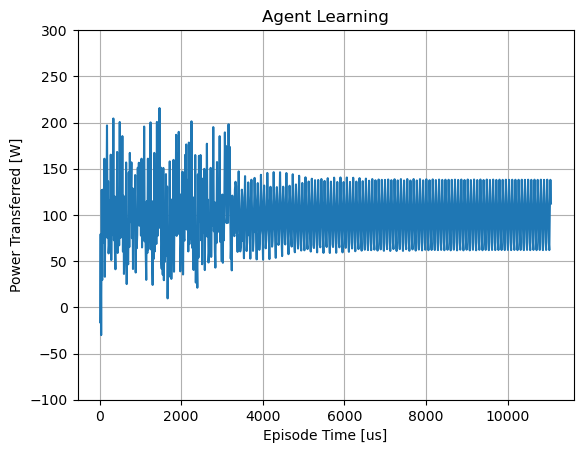

In [9]:
train_agent(min_ac, max_ac, 10, False)
max_ac = torch.ones(1,)*(0.5/70000)*1e6
min_ac = torch.ones(1,)*(0.5/81000)*1e6
print(max_ac)
print(min_ac)
my_agent.agent_clear_hist()
rewards, actions, powers, actions_og = train_agent(min_ac, max_ac, 601, True)

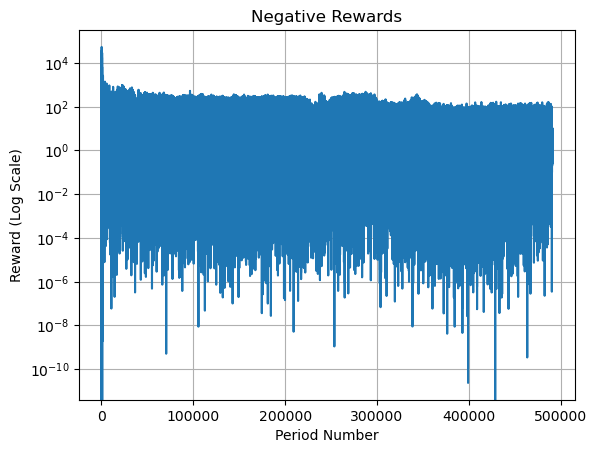

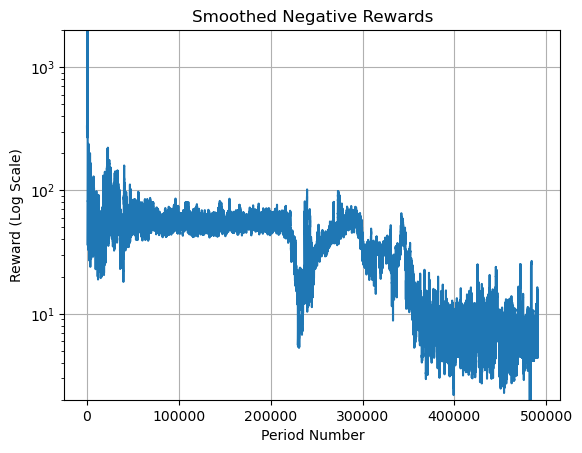

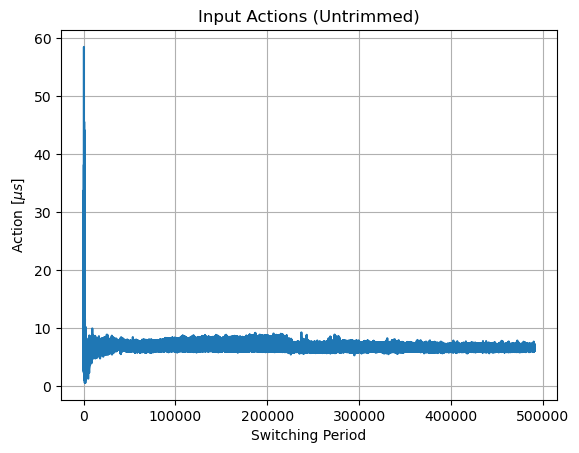

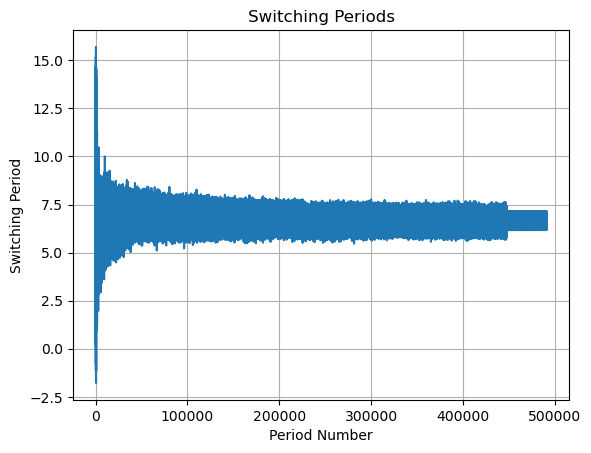

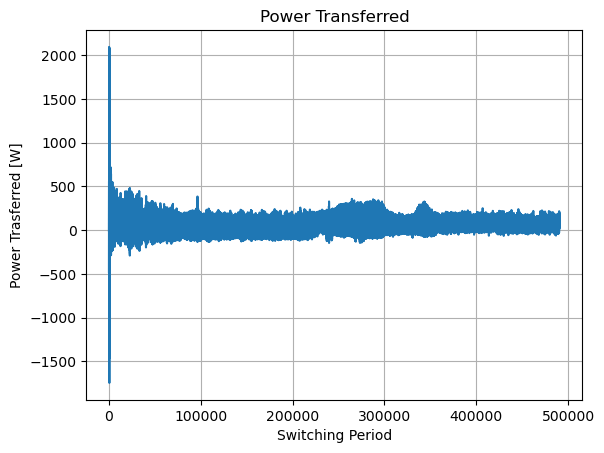

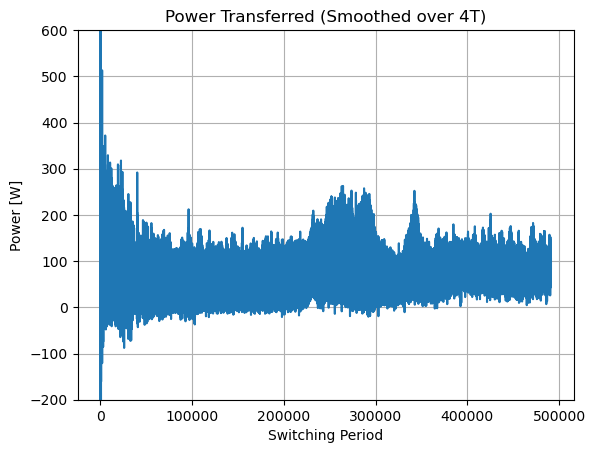

In [22]:
rewards2 = [-rew for rew in rewards]
x = range(len(rewards))
plt.semilogy(x, rewards2)
plt.xlabel('Period Number')
plt.title('Negative Rewards')
plt.ylabel('Reward (Log Scale)')
plt.grid()
plt.savefig('Rewards.png')
plt.show()

n = 100
filt = np.ones((n, )) / n
rew_temp = np.array(rewards2).reshape((-1,))
rewards3 = np.convolve(rew_temp, filt, 'valid')
plt.semilogy(range(len(rewards3)), rewards3)
plt.xlabel('Period Number')
plt.title('Smoothed Negative Rewards')
plt.ylabel('Reward (Log Scale)')
plt.ylim([2, 2e3])
plt.grid()
plt.savefig('Rewards_smooth.png')
plt.show()

plt.plot(x, actions_og)
plt.title('Input Actions (Untrimmed)')
plt.grid()
plt.xlabel('Switching Period')
plt.ylabel('Action [$\mu s$]')
plt.savefig('Actions_og.png')
plt.show()

plt.plot(x, actions)
plt.title('Switching Periods')
plt.xlabel('Period Number')
plt.ylabel('Switching Period')
plt.grid()
plt.savefig('Actions.png')
plt.show()

plt.plot(x, powers)
plt.xlabel('Switching Period')
plt.title('Power Transferred')
plt.ylabel('Power Trasferred [W]')
plt.grid()
plt.savefig('Power_t.png')
plt.show()

p_arr = np.array(powers)
n = 4
filt = np.ones((n, )) / n
p_arr = np.convolve(p_arr, filt, mode='valid')
plt.plot(range(len(p_arr)), p_arr)
plt.xlabel('Switching Period')
plt.title('Power Transferred (Smoothed over 4T)')
plt.ylabel('Power [W]')
plt.grid()
plt.ylim([-200, 600])
plt.savefig('Power_t_filt.png')
plt.show()

In [21]:
#fwrite = open('my_agent.pkl', 'wb')
#pickle.dump(my_agent, fwrite)
#fwrite.close()
#fwrite = open('train_data.pkl', 'wb')
#pickle.dump([rewards, actions, powers, actions_og], fwrite)
#fwrite.close()
fread = open('my_agent.pkl', 'rb')
my_agent = pickle.load(fread)
fread.close()
fread = open('train_data.pkl', 'rb')
[rewards, actions, powers, actions_og] = pickle.load(fread)
fread.close()
max_ac = torch.ones(1,)*(0.5/70000)*1e6
min_ac = torch.ones(1,)*(0.5/81000)*1e6
#dir()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


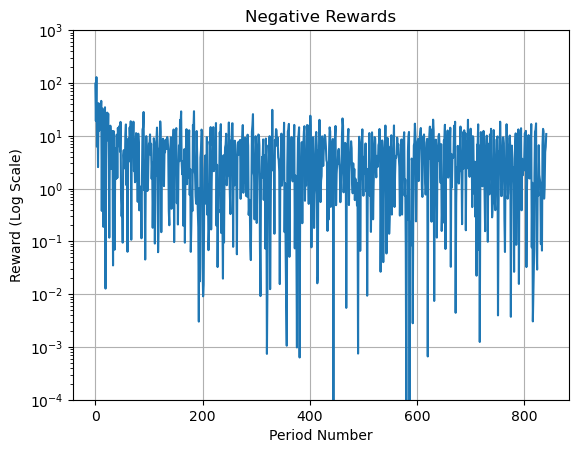

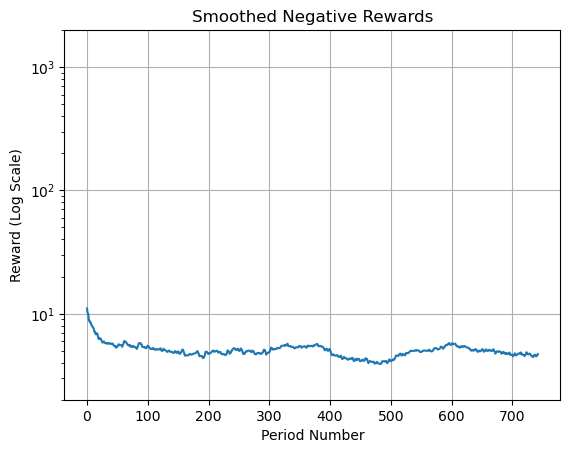

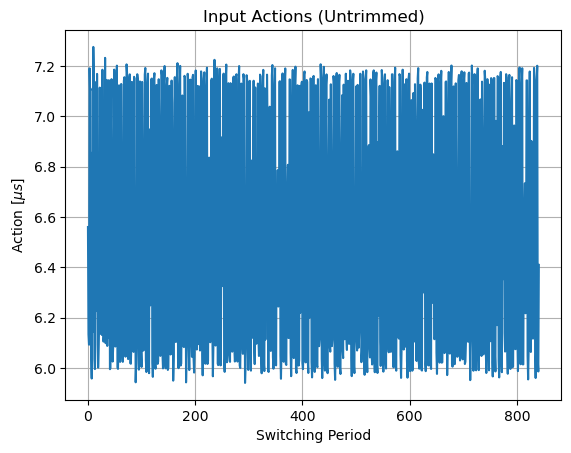

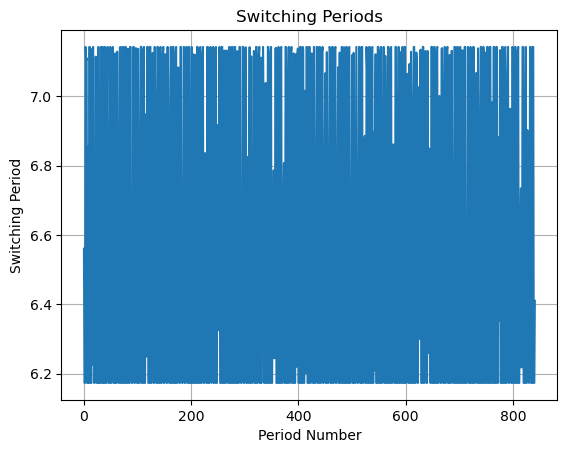

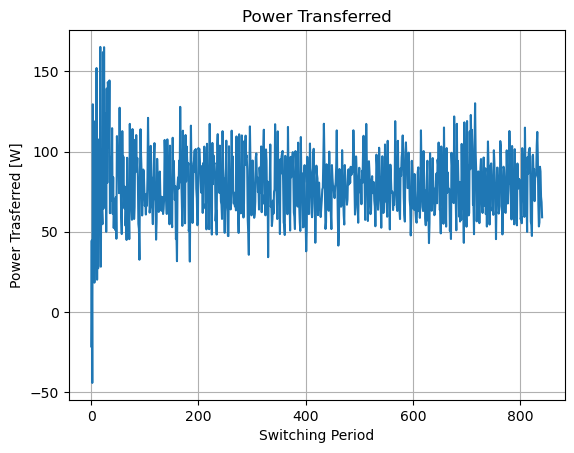

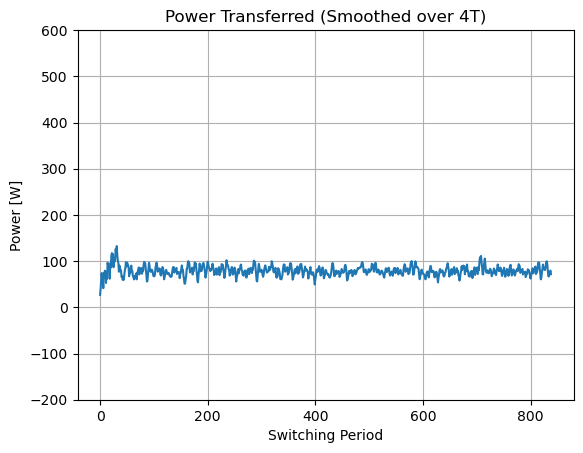

In [23]:
#Now, repeat the experiment but with no noise on the input values
rewards, actions, powers, actions_og = train_agent(min_ac, max_ac, 1, False)
rewards2 = [-rew for rew in rewards]
rewards2 = np.array(rewards2)
x = range(len(rewards))
plt.clf()
plt.semilogy(x, rewards2)
plt.xlabel('Period Number')
plt.title('Negative Rewards')
plt.ylabel('Reward (Log Scale)')
plt.ylim([1e-4, 1e3])
plt.grid()
plt.savefig('real_Rewards.png')
plt.show()

n = 100
filt = np.ones((n, )) / n
rew_temp = np.array(rewards2).reshape((-1,))
rewards3 = np.convolve(rew_temp, filt, 'valid')
plt.semilogy(range(len(rewards3)), rewards3)
plt.xlabel('Period Number')
plt.title('Smoothed Negative Rewards')
plt.ylabel('Reward (Log Scale)')
plt.ylim([2, 2e3])
plt.grid()
plt.savefig('real_Rewards_smooth.png')
plt.show()

plt.plot(x, actions_og)
plt.title('Input Actions (Untrimmed)')
plt.grid()
plt.xlabel('Switching Period')
plt.ylabel('Action [$\mu s$]')
plt.savefig('real_Actions_og.png')
plt.show()

plt.plot(x, actions)
plt.title('Switching Periods')
plt.xlabel('Period Number')
plt.ylabel('Switching Period')
plt.grid()
plt.savefig('real_Actions.png')
plt.show()

plt.plot(x, powers)
plt.xlabel('Switching Period')
plt.title('Power Transferred')
plt.ylabel('Power Trasferred [W]')
plt.grid()
plt.savefig('real_Power_t.png')
plt.show()

p_arr = np.array(powers)
n = 4
filt = np.ones((n, )) / n
p_arr = np.convolve(p_arr, filt, mode='valid')
plt.plot(range(len(p_arr)), p_arr)
plt.xlabel('Switching Period')
plt.title('Power Transferred (Smoothed over 4T)')
plt.ylabel('Power [W]')
plt.grid()
plt.ylim([-200, 600])
plt.savefig('real_Power_t_filt.png')
plt.show()

In [30]:
print(min(rewards2))
#print(np.log(rewards2))
print(len(rewards2))

[7.986906e-07]
841
